# Autoencoder

In [1]:
import numpy as np
import tensorboard
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from sklearn.datasets import make_swiss_roll

from nnDataloader import get_data_loaders
from nnTrainer import train_autoencoder_swiss_roll, train_word2vec_autoencoder
from nnAutoencoder import Autoencoder
from nnVariationalAE import VariationalAutoencoder

pl.seed_everything(42)

plt.rcParams['figure.dpi'] = 200
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Global seed set to 42


In [2]:
writer = SummaryWriter("tensorboard/")
%load_ext tensorboard
%tensorboard --logdir tensorboard/

Reusing TensorBoard on port 6006 (pid 8233), started 0:31:31 ago. (Use '!kill 8233' to kill it.)

In [3]:
N_DATA  = 100000

Generate data in a reproducible way

In [4]:
DATA, LABELS = make_swiss_roll(N_DATA)
DATA = torch.Tensor(DATA)

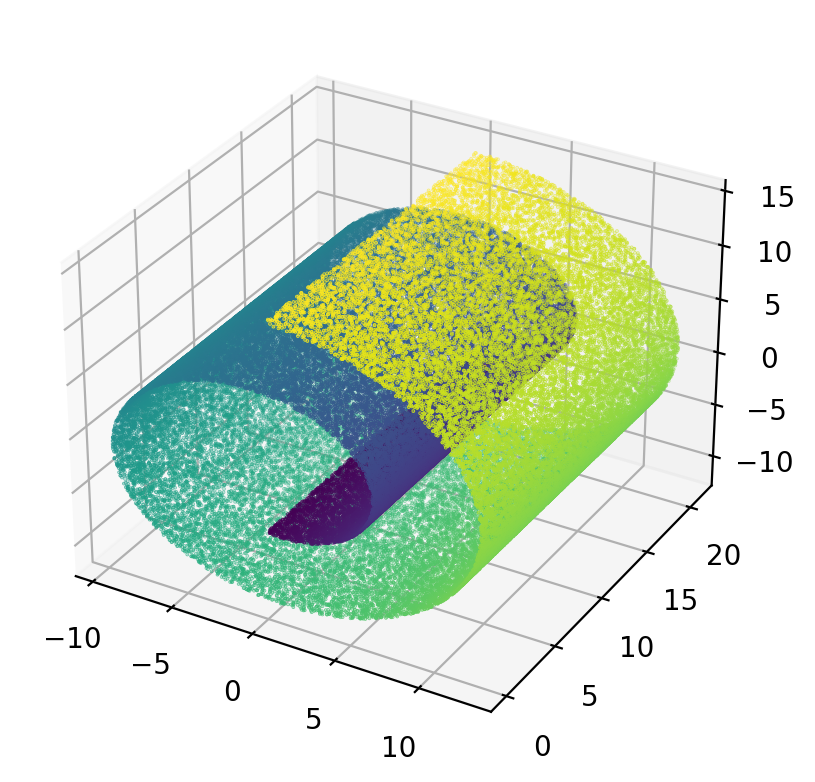

In [5]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*DATA.T, s=0.1, c=LABELS)
plt.show()

In [6]:
train_val_test_loaders = get_data_loaders(DATA)

In [17]:
# model, result = train_autoencoder(*train_val_test_loaders, latent_dim=2, data_dim=3)

In [18]:
# encoded_data = model.encoder(DATA).detach().numpy()
# plt.scatter(encoded_data[:,0], encoded_data[:,1], s=0.01, c=LABELS)
# plt.show()

In [19]:
# %matplotlib inline
# reconstructed_data = model(DATA).detach().numpy()
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter3D(*reconstructed_data.T, s=0.01, c=LABELS)
# plt.show()

## Try Variational Autoencoder

In [9]:
model, result = train_variational_autoencoder(*train_val_test_loaders, latent_dim=2, data_dim=3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes | Out sizes
-----------------------------------------------------------
0 | encoder | Encoder | 527 K  | [3]      | [2]      
1 | decoder | Decoder | 527 K  | [2]      | [3]      
-----------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.223     Total estimated model params size (MB)


Epoch 199: 100%|██████████| 11/11 [00:00<00:00, 15.15it/s, loss=4, v_num=22]   

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 11/11 [00:00<00:00, 14.81it/s, loss=4, v_num=22]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 30.39it/s] 


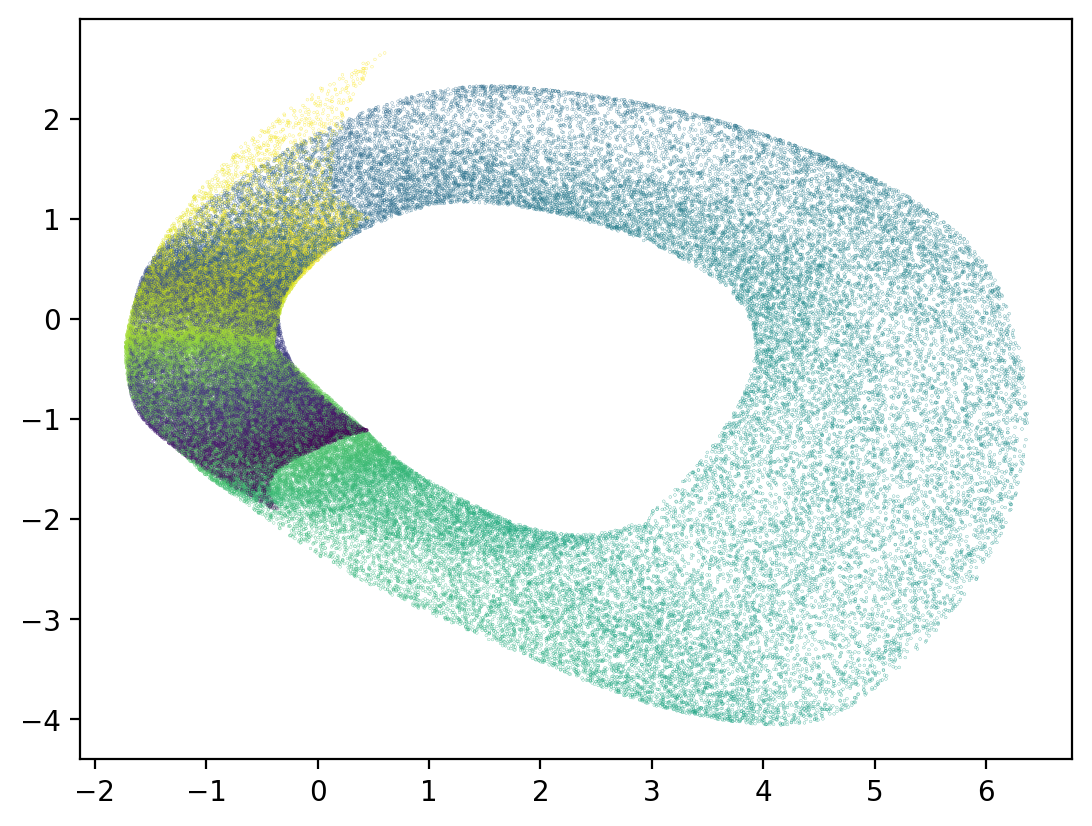

In [24]:
encoded_data = model.encoder(DATA).detach().numpy()
plt.scatter(encoded_data[:,0], encoded_data[:,1], s=0.01, c=LABELS)
plt.show()

In [26]:
%matplotlib inline
model = model.cuda()
reconstructed_data = model(DATA.cuda())
reconstructed_data = reconstructed_data.cpu().detach().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*reconstructed_data.T, s=0.01, c=LABELS)
plt.show()

Using matplotlib backend: QtAgg


## Cherry-Pick Best Model
After trying out 40

In [18]:
model = Autoencoder.load_from_checkpoint("./tensorboard/lightning_logs/version_28/checkpoints/epoch=199-step=1800.ckpt")

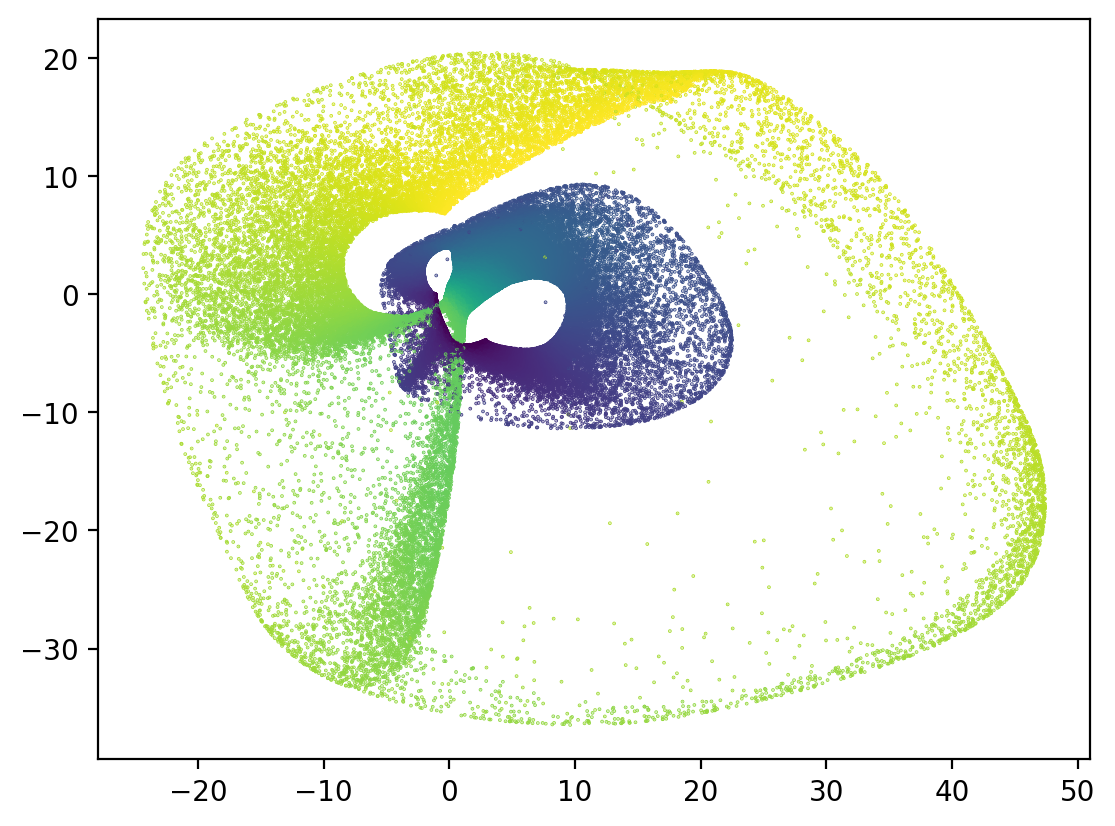

In [19]:
encoded_data = model.encoder(DATA).detach().numpy()
plt.scatter(encoded_data[:,0], encoded_data[:,1], s=0.1, c=LABELS)
plt.show()

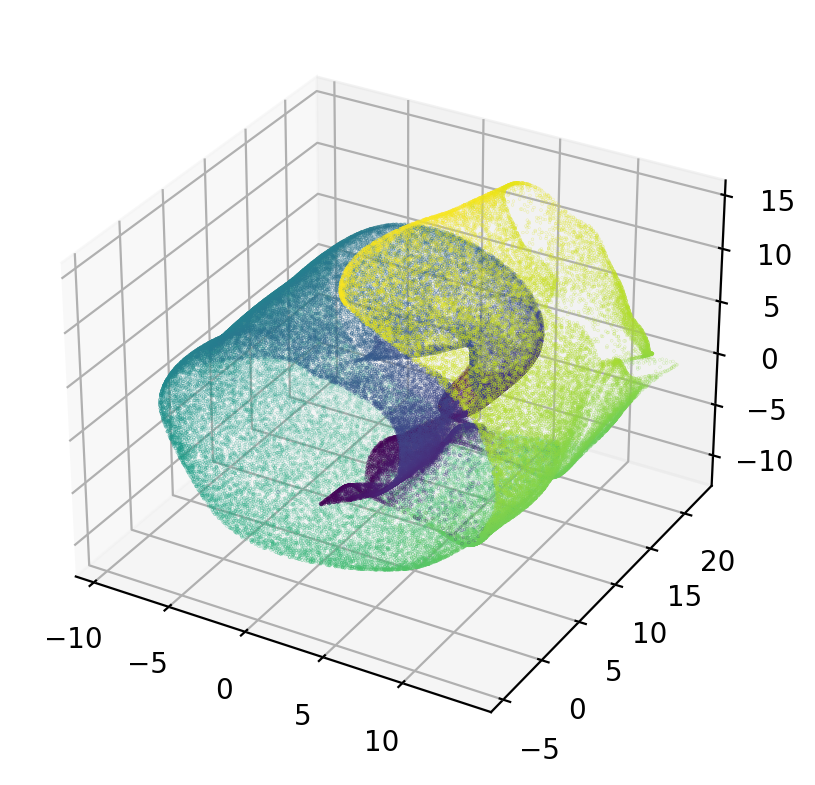

In [20]:
%matplotlib inline
reconstructed_data = model(DATA).detach().numpy()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(*reconstructed_data.T, s=0.01, c=LABELS)
plt.show()

## Word2Vec

For the Word2Vec dataset we use an Autoencoder to 

In [2]:
from gensim.models import Word2Vec
import gensim.downloader

You may specify the local subdirectory for saving gensim data using the GENSIM_DATA_DIR environment variable. For example:
```
$ export GENSIM_DATA_DIR=/tmp/gensim-data $ python -m gensim.downloader –download <dataname>
```
By default, this subdirectory is ~/gensim-data.

In [3]:
google_news_300_vectors = gensim.downloader.load('word2vec-google-news-300')

In [4]:
vecs = google_news_300_vectors.vectors
# id_to_key = google_news_300_vectors.index_to_key
VECS = torch.Tensor(vecs)

Normalize Input

In [5]:
# VECS = VECS - torch.mean(VECS, dim=0)
# VECS = 2 * (VECS + VECS.min()) / (VECS.max() - VECS.min()) - 1
# VECS = torch.nn.functional.normalize(VECS, p=1, dim=1)
# torch.norm(VECS, p=1, dim=1)

In [6]:
vec_loaders = get_data_loaders(VECS, batch_size=16000, train_ratio=1, val_ratio=0, test_ratio=0)
loader, _, _ = vec_loaders

In [9]:
model, result = train_word2vec_autoencoder(loader, latent_dim=100, data_dim=300)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes | Out sizes
-----------------------------------------------------------
0 | encoder | Encoder | 2.0 M  | [300]    | [100]    
1 | decoder | Decoder | 2.0 M  | [100]    | [300]    
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.353    Total estimated model params size (MB)


Epoch 6: 100%|██████████| 188/188 [00:35<00:00,  5.32it/s, loss=11, v_num=14]      


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 188/188 [00:11<00:00, 16.00it/s]


: 

In [ ]:
# vec_model = Autoencoder(300, 300, 100).cuda()
# optim = torch.optim.Adam(vec_model.parameters(), lr=1e-3)
# from torchinfo import summary
# summary(vec_model)
# for epoch in range(10):
#     for id, batch in enumerate(train_loader):
#         batch = batch.cuda()
#         optim.zero_grad()
#         loss = vec_model.training_step(batch, id)
#         loss.backward()
#         optim.step()
#         if id % 50 == 0:
#             print("Loss:", loss)
#     print("EPOCH :", epoch)